# Use Dual DQN to Play MoutainCar-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('MountainCar-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

12:57:29 [INFO] env: <MountainCarEnv<MountainCar-v0>>
12:57:29 [INFO] action_space: Discrete(3)
12:57:29 [INFO] observation_space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
12:57:29 [INFO] reward_range: (-inf, inf)
12:57:29 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
12:57:29 [INFO] _max_episode_steps: 200
12:57:29 [INFO] _elapsed_steps: None


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class DualNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(DualNet, self).__init__()
        self.common_net = nn.Sequential(nn.Linear(input_size, 64), nn.ReLU())
        self.advantage_net = nn.Sequential(nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, output_size))
        self.v_net = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 1))

    def forward(self, s):
        h = self.common_net(s)
        adv = self.advantage_net(h)
        adv = adv - adv.mean(1).unsqueeze(1)
        v = self.v_net(h)
        q = v + adv 
        return q


class DualDQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.evaluate_net = DualNet(input_size=env.observation_space.shape[0],
                output_size=self.action_n)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net = copy.deepcopy(self.evaluate_net)

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.rand() < 0.001:
            # epsilon-greedy policy in train mode
            action = np.random.randint(self.action_n)
        else:
            state_tensor = torch.as_tensor(observation,
                    dtype=torch.float).reshape(1, -1)
            q_tensor = self.evaluate_net(state_tensor)
            action_tensor = torch.argmax(q_tensor)
            action = action_tensor.item()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, action, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, action, reward, next_state, done)
            if self.replayer.count >= self.replayer.capacity * 0.95:
                    # skip first few episodes for speed
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(1024) # replay transitions
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # train
        next_eval_q_tensor = self.evaluate_net(next_state_tensor)
        next_action_tensor = next_eval_q_tensor.argmax(axis=-1)
        next_q_tensor = self.target_net(next_state_tensor)
        next_max_q_tensor = torch.gather(next_q_tensor, 1,
                next_action_tensor.unsqueeze(1)).squeeze(1)
        target_tensor = reward_tensor + self.gamma * (1. - done_tensor) * \
                next_max_q_tensor
        pred_tensor = self.evaluate_net(state_tensor)
        unsqueeze_tensor = action_tensor.unsqueeze(1)
        q_tensor = pred_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        loss_tensor = self.loss(target_tensor, q_tensor)
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = DualDQNAgent(env)

12:57:29 [INFO] ==== train ====
12:57:29 [DEBUG] train episode 0: reward = -200.00, steps = 200


12:57:29 [DEBUG] train episode 1: reward = -200.00, steps = 200
12:57:29 [DEBUG] train episode 2: reward = -200.00, steps = 200
12:57:30 [DEBUG] train episode 3: reward = -200.00, steps = 200
12:57:30 [DEBUG] train episode 4: reward = -200.00, steps = 200
12:57:30 [DEBUG] train episode 5: reward = -200.00, steps = 200
12:57:30 [DEBUG] train episode 6: reward = -200.00, steps = 200
12:57:30 [DEBUG] train episode 7: reward = -200.00, steps = 200
12:57:30 [DEBUG] train episode 8: reward = -200.00, steps = 200
12:57:30 [DEBUG] train episode 9: reward = -200.00, steps = 200
12:57:31 [DEBUG] train episode 10: reward = -200.00, steps = 200
12:57:31 [DEBUG] train episode 11: reward = -200.00, steps = 200
12:57:31 [DEBUG] train episode 12: reward = -200.00, steps = 200
12:57:31 [DEBUG] train episode 13: reward = -200.00, steps = 200
12:57:31 [DEBUG] train episode 14: reward = -200.00, steps = 200
12:57:31 [DEBUG] train episode 15: reward = -200.00, steps = 200
12:57:31 [DEBUG] train episode 16:

13:07:07 [DEBUG] train episode 127: reward = -200.00, steps = 200
13:07:14 [DEBUG] train episode 128: reward = -200.00, steps = 200
13:07:21 [DEBUG] train episode 129: reward = -200.00, steps = 200
13:07:28 [DEBUG] train episode 130: reward = -200.00, steps = 200
13:07:35 [DEBUG] train episode 131: reward = -200.00, steps = 200
13:07:42 [DEBUG] train episode 132: reward = -200.00, steps = 200
13:07:49 [DEBUG] train episode 133: reward = -200.00, steps = 200
13:07:56 [DEBUG] train episode 134: reward = -200.00, steps = 200
13:08:03 [DEBUG] train episode 135: reward = -200.00, steps = 200
13:08:10 [DEBUG] train episode 136: reward = -200.00, steps = 200
13:08:17 [DEBUG] train episode 137: reward = -200.00, steps = 200
13:08:25 [DEBUG] train episode 138: reward = -200.00, steps = 200
13:08:32 [DEBUG] train episode 139: reward = -200.00, steps = 200
13:08:39 [DEBUG] train episode 140: reward = -200.00, steps = 200
13:08:46 [DEBUG] train episode 141: reward = -200.00, steps = 200
13:08:53 [

13:21:57 [DEBUG] train episode 252: reward = -200.00, steps = 200
13:22:04 [DEBUG] train episode 253: reward = -200.00, steps = 200
13:22:11 [DEBUG] train episode 254: reward = -200.00, steps = 200
13:22:18 [DEBUG] train episode 255: reward = -200.00, steps = 200
13:22:25 [DEBUG] train episode 256: reward = -200.00, steps = 200
13:22:32 [DEBUG] train episode 257: reward = -200.00, steps = 200
13:22:39 [DEBUG] train episode 258: reward = -200.00, steps = 200
13:22:47 [DEBUG] train episode 259: reward = -200.00, steps = 200
13:22:54 [DEBUG] train episode 260: reward = -200.00, steps = 200
13:23:01 [DEBUG] train episode 261: reward = -200.00, steps = 200
13:23:08 [DEBUG] train episode 262: reward = -200.00, steps = 200
13:23:15 [DEBUG] train episode 263: reward = -200.00, steps = 200
13:23:22 [DEBUG] train episode 264: reward = -200.00, steps = 200
13:23:29 [DEBUG] train episode 265: reward = -200.00, steps = 200
13:23:36 [DEBUG] train episode 266: reward = -200.00, steps = 200
13:23:43 [

13:36:37 [DEBUG] train episode 377: reward = -200.00, steps = 200
13:36:44 [DEBUG] train episode 378: reward = -200.00, steps = 200
13:36:51 [DEBUG] train episode 379: reward = -200.00, steps = 200
13:36:58 [DEBUG] train episode 380: reward = -200.00, steps = 200
13:37:05 [DEBUG] train episode 381: reward = -200.00, steps = 200
13:37:12 [DEBUG] train episode 382: reward = -200.00, steps = 200
13:37:19 [DEBUG] train episode 383: reward = -200.00, steps = 200
13:37:26 [DEBUG] train episode 384: reward = -200.00, steps = 200
13:37:33 [DEBUG] train episode 385: reward = -200.00, steps = 200
13:37:40 [DEBUG] train episode 386: reward = -200.00, steps = 200
13:37:47 [DEBUG] train episode 387: reward = -200.00, steps = 200
13:37:54 [DEBUG] train episode 388: reward = -200.00, steps = 200
13:38:02 [DEBUG] train episode 389: reward = -200.00, steps = 200
13:38:09 [DEBUG] train episode 390: reward = -200.00, steps = 200
13:38:16 [DEBUG] train episode 391: reward = -200.00, steps = 200
13:38:23 [

13:48:11 [DEBUG] test episode 6: reward = -88.00, steps = 88
13:48:11 [DEBUG] test episode 7: reward = -154.00, steps = 154
13:48:11 [DEBUG] test episode 8: reward = -115.00, steps = 115
13:48:11 [DEBUG] test episode 9: reward = -114.00, steps = 114
13:48:12 [DEBUG] test episode 10: reward = -85.00, steps = 85
13:48:12 [DEBUG] test episode 11: reward = -113.00, steps = 113
13:48:12 [DEBUG] test episode 12: reward = -165.00, steps = 165
13:48:12 [DEBUG] test episode 13: reward = -115.00, steps = 115
13:48:12 [DEBUG] test episode 14: reward = -113.00, steps = 113
13:48:12 [DEBUG] test episode 15: reward = -113.00, steps = 113
13:48:12 [DEBUG] test episode 16: reward = -113.00, steps = 113
13:48:12 [DEBUG] test episode 17: reward = -115.00, steps = 115
13:48:12 [DEBUG] test episode 18: reward = -117.00, steps = 117
13:48:12 [DEBUG] test episode 19: reward = -156.00, steps = 156
13:48:12 [DEBUG] test episode 20: reward = -116.00, steps = 116
13:48:12 [DEBUG] test episode 21: reward = -113.

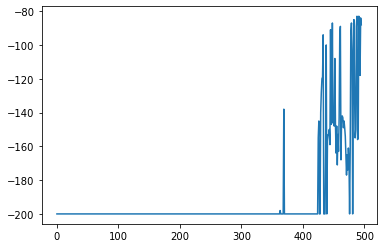

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -110:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()